In [121]:
import yfinance as yf
import talib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import pyplot
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
%matplotlib inline

ticker = ["bud"]
stock_data = yf.download(ticker, start="2019-04-20", end="2022-04-20")

[*********************100%***********************]  1 of 1 completed


In [122]:
stock_data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-04-22,89.690002,90.470001,89.580002,89.599998,85.097206,970800
2019-04-23,88.559998,89.790001,88.500000,89.250000,84.764793,755500
2019-04-24,89.019997,89.129997,87.820000,88.209999,83.777061,1038400
2019-04-25,86.889999,87.019997,86.000000,86.639999,82.285965,1341700
2019-04-26,87.379997,87.629997,86.830002,87.580002,83.178719,920400


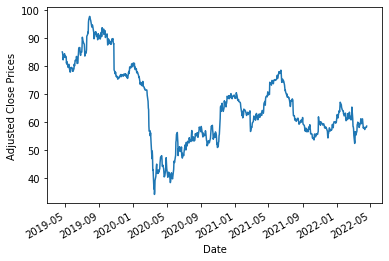

In [123]:

stock_data['Adj Close'].plot()
plt.ylabel("Adjusted Close Prices")
plt.show()

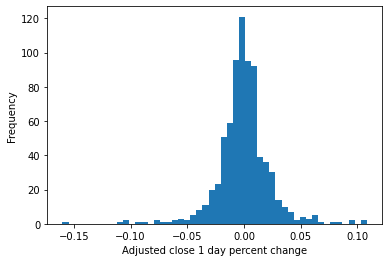

In [124]:
stock_data['Adj Close'].pct_change().plot.hist(bins=50)
plt.xlabel("Adjusted close 1 day percent change")
plt.show()

In [125]:

feature_names = []
for n in [14, 30, 50, 200]:
    stock_data['ma' + str(n)] = talib.SMA(stock_data['Adj Close'].values, timeperiod=n)
    stock_data['rsi' + str(n)] = talib.RSI(stock_data['Adj Close'].values, timeperiod=n)

    feature_names = feature_names + ['ma' + str(n), 'rsi' + str(n)]

In [126]:
stock_data['Volume_1d_change'] = stock_data['Volume'].pct_change()
volume_features = ['Volume_1d_change']
feature_names.extend(volume_features)



In [127]:
stock_data['5d_future_close'] = stock_data['Adj Close'].shift(-5)
stock_data['5d_close_future_pct'] = stock_data['5d_future_close'].pct_change(5)

In [128]:
stock_data.head()

,Open,High,Low,Close,Adj Close,Volume,ma14,rsi14,ma30,rsi30,ma50,rsi50,ma200,rsi200,Volume_1d_change,5d_future_close,5d_close_future_pct
Date,,,,,,,,,,,,,,,,,
2019-04-22,89.690002,90.470001,89.580002,89.599998,85.097206,970800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,83.587112,NaN
2019-04-23,88.559998,89.790001,88.500000,89.250000,84.764793,755500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.221776,84.470375,NaN
2019-04-24,89.019997,89.129997,87.820000,88.209999,83.777061,1038400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.374454,83.397156,NaN
2019-04-25,86.889999,87.019997,86.000000,86.639999,82.285965,1341700,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.292084,83.140732,NaN
2019-04-26,87.379997,87.629997,86.830002,87.580002,83.178719,920400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.314005,83.672585,NaN


In [129]:
stock_data.dropna(inplace=True)

X = stock_data[feature_names]
y = stock_data['5d_close_future_pct']

train_size = int(0.85 * y.shape[0])
X_train = X[:train_size]
y_train = y[:train_size]
X_test = X[train_size:]
y_test = y[train_size:]


In [130]:
y_train

Date
2020-02-05   -0.034042
2020-02-06   -0.037482
2020-02-07   -0.018048
2020-02-10   -0.014613
2020-02-11   -0.005808
                ...   
2021-12-06   -0.015537
2021-12-07   -0.010096
2021-12-08    0.002075
2021-12-09    0.034843
2021-12-10    0.032286
Name: 5d_close_future_pct, Length: 468, dtype: float64

In [131]:
rf_model = RandomForestRegressor(n_estimators=500, max_depth=5, max_features=4, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=5, max_features=4, n_estimators=500,
                      random_state=42)

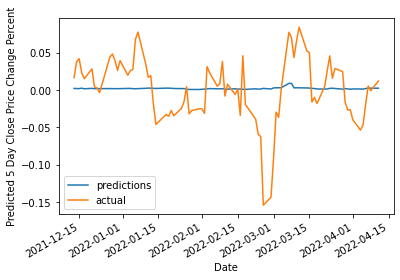

In [132]:
# TEST DATA

y_pred = rf_model.predict(X_test)

y_pred_df = pd.DataFrame(
    {"predictions":y_pred,
    "actual":y_test
    }
)

y_pred_df.plot()
plt.ylabel("Predicted 5 Day Close Price Change Percent")
plt.show() 

<AxesSubplot:xlabel='Date'>

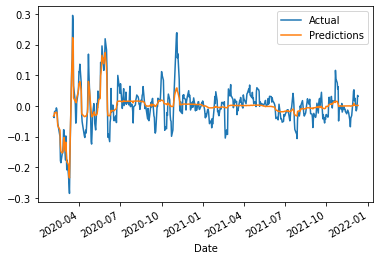

In [133]:
y_train_pred = rf_model.predict(X_train)

y_train_df = pd.DataFrame({
    "Actual":y_train,
    "Predictions":y_train_pred
})

y_train_df.plot()

In [134]:
# calculate MSE

In [135]:
y_pred_series

,predictions,actual
Date,,
2021-12-13,0.085170,-0.060150
2021-12-14,0.090763,0.055738
2021-12-15,0.082978,0.010787
2021-12-16,0.090055,0.052516
2021-12-17,0.069802,-0.014599
...,...,...
2022-04-05,0.075710,-0.082544
2022-04-06,0.074899,-0.009749
2022-04-07,0.084125,0.014881


In [136]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 0.03288542106443091
Mean Squared Error: 0.0018121352869678383
Root Mean Squared Error: 0.042569182361983864


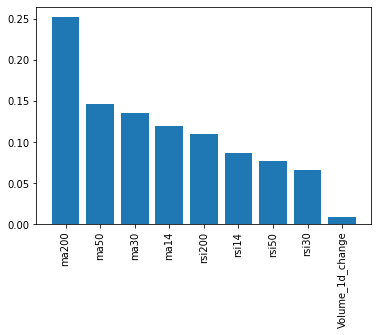

In [137]:
importances = rf_model.feature_importances_
sorted_index = np.argsort(importances)[::-1]
x_values = range(len(importances))
labels = np.array(feature_names)[sorted_index]
plt.bar(x_values, importances[sorted_index], tick_label=labels)
plt.xticks(rotation=90)
plt.show()